In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from math import pow
import re
import math

from sklearn.impute import KNNImputer

%matplotlib inline

In [2]:
# Read in academic performance (assessment results) file for Seattle School District
df_assessment = pd.read_csv('data/seattle_assessment.csv')

#check data 
print (df_assessment.shape)
df_assessment.head (3)

(181042, 30)


,SchoolYear,OrganizationLevel,County,ESDName,ESDOrganizationID,DistrictCode,DistrictName,DistrictOrganizationId,SchoolCode,SchoolName,...,CountMetStandard,Count of students expected to test including previously passed,PercentMetStandard,PercentLevel1,PercentLevel2,PercentLevel3,PercentLevel4,PercentMetTestedOnly,Percent No Score,DataAsOf
0,2018-19,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,NaN,NaN,Suppressed: N<10,NaN,NaN,NaN,NaN,NaN,NaN,09/27/2019 12:00:00 AM
1,2017-18,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,NaN,NaN,Suppressed: N<10,NaN,NaN,NaN,NaN,NaN,NaN,09/27/2019 12:00:00 AM
2,2016-17,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,NaN,NaN,Suppressed: N<10,NaN,NaN,NaN,NaN,NaN,NaN,09/27/2019 12:00:00 AM


In [3]:
#get unique column values
for col in df_assessment.columns:
    print (col, " :: ", df_assessment[col].unique())

SchoolYear  ::  ['2018-19' '2017-18' '2016-17' '2015-16' '2014-15']
OrganizationLevel  ::  ['School' 'District']
County  ::  ['King']
ESDName  ::  ['Puget Sound Educational Service District 121']
ESDOrganizationID  ::  [100006]
DistrictCode  ::  [17001]
DistrictName  ::  ['Seattle School District #1']
DistrictOrganizationId  ::  [100229]
SchoolCode  ::  [2138. 3774. 2181. 2730. 3717. 2307. 2220. 2070. 5406. 2209. 2372. 1751.
 5292. 2838. 5487. 3096. 2392. 2199. 2450. 2839. 3803. 2321. 2729. 5485.
 1750. 2118. 3518. 2182. 2090. 2306. 2139. 3429. 3378. 2061. 2123. 2371.
 4248. 5175. 2269. 4277. 3276. 3496. 5405. 1635. 5351. 2063. 2143. 2975.
 2081. 3478. 2733. 2437. 2183. 2121. 3874. 5276. 3714. 2462. 2435. 2069.
 2353. 2089. 3517. 5203. 2201. 3095. 1547. 2322. 3479. 3218. 3027. 3868.
 2976. 2256. 4065. 1620. 5046. 5204. 3327. 3380. 4263. 2120. 5486. 2285.
 3157. 3028. 1796. 5205. 3665. 1596. 3778. 4218. 5488. 2080. 5500. 1856.
 3974. 2141. 1579. 2667. 2977. 4064. 3026. 2645. 2234. 2142.

In [4]:
#remove single entry column, and unused columns
df_assessment = df_assessment.drop(['County','ESDName','ESDOrganizationID',\
                                    'DistrictCode','DistrictName',\
                                    'DistrictOrganizationId', 'DataAsOf',\
                                    'SchoolName' ],axis=1)


In [5]:
#define function to convert percentage (string) to float
def pctStringToFloat (s):
    
    if (re.match(r'^(\<[\%\.\d]+)$', s)): # for '<x%' return x-0.5 as float
        return float(s[1:-1]) - 0.5

    if (re.match(r'^(\>[\%\.\d]+)$', s)): # for '>x%' return x+0.5 as float
        return float(s[1:-1]) + 0.5

    if (re.match(r'^([\%\.\d]+)$', s)):
        return float(s[:-1])
    return None


In [6]:
# convert percentage string to float
df_assessment['PercentMetStandard'] = df_assessment['PercentMetStandard'].\
                                      apply(lambda x: pctStringToFloat(x))

# below accommodates 'nan'
cnamelist = ['PercentLevel1','PercentLevel2','PercentLevel3','PercentLevel4']
for cname in cnamelist:
    df_assessment[cname] = df_assessment[cname].str.replace('\%','')
    df_assessment[cname] = df_assessment[cname].apply(pd.to_numeric,errors='coerce')


In [7]:
# check types of tests 
print(df_assessment[['Test Administration (group)','TestAdministration','TestSubject','GradeLevel','SchoolYear']].\
      drop_duplicates().groupby(['Test Administration (group)','TestAdministration','TestSubject']).agg(['count']))

# will use General tests in the analysis (SBAC Math+ELA, and WCAS science)

                                                                     GradeLevel  \
                                                                          count   
Test Administration (group) TestAdministration TestSubject                        
Alternate                   AIM                English Language Arts         40   
                                               Math                          40   
                                               Science                       19   
                            WIDA               WIDA                          23   
General                     SBAC               English Language Arts         40   
                                               Math                          40   
                            WCAS               Science                        8   
Other                       ELPA               ELPA                          56   
                            EOC                Biology                        6   
    

In [8]:
#select columns
df_assessment = df_assessment[['OrganizationLevel','SchoolCode','SchoolOrganizationid','CurrentSchoolType',\
                               'Test Administration (group)', 'TestAdministration', 'TestSubject','Suppression',\
                              'SchoolYear','StudentGroupType', 'StudentGroup','GradeLevel',\
                              'PercentMetStandard', 'PercentLevel1', 'PercentLevel2', 'PercentLevel3','PercentLevel4']]


In [9]:
# Read in Discipline data file
df_discipline = pd.read_csv('data/seattle_discipline.csv')

df_discipline.columns

Index(['SchoolYear', 'OrganizationLevel', 'County', 'ESDName',
       'ESDOrganizationId', 'DistrictCode', 'DistrictName',
       'DistrictOrganizationId', 'SchoolCode', 'SchoolName',
       'SchoolOrganizationId', 'CurrentSchoolType', 'Student Group',
       'GradeLevel', 'DisciplineSuppressionNotes', 'DisciplineDenominator',
       'DisciplineNumerator', 'DisciplineRate', 'Excluded1DayOrLess',
       'Excluded2To3Days', 'Excluded4To5Days', 'Excluded6To10Days',
       'Excluded10DaysOrMore', 'DateExtracted'],
      dtype='object')

In [10]:
#remove single entry column and unwanted columns
df_discipline = df_discipline.drop(['County','ESDName','ESDOrganizationId','DistrictCode','DistrictName','DistrictOrganizationId'],axis=1)
df_discipline = df_discipline.drop(['DateExtracted','SchoolName'],axis=1)

#change selected column names to match spelling in df_assessment
df_discipline.columns = ['SchoolYear', 'OrganizationLevel', 'SchoolCode', 'SchoolOrganizationid',
                         'CurrentSchoolType', 'StudentGroup', 'GradeLevel',
                         'DisciplineSuppressionNotes', 'DisciplineDenominator','DisciplineNumerator', 
                         'DisciplineRate', 'Excluded1DayOrLess','Excluded2To3Days', 'Excluded4To5Days', 
                         'Excluded6To10Days','Excluded10DaysOrMore']

In [11]:
# change pct string to float (for those suppressed or <xx% --> put as nan)
def pctStringToFloat2 (s):
    
    if (re.match(r'^(\<[\%\.\d]+)$', s)): # for '<x%' return x-0.5 as float
        return float(s[1:-1]) - 0.5
    
    if (re.match(r'^([\%\.\d]+)$', s)):
        return float(s[:-1])
    return None

df_discipline['DisciplineRate'] = df_discipline['DisciplineRate'].apply(lambda x: pctStringToFloat2(x))
    

In [12]:
# Read in sqss file (data for attendance, 9th grade on track, and dual credits)
df_sqss = pd.read_csv('data/seattle_sqss.csv')

df_sqss.columns

Index(['SchoolYear', 'OrganizationLevel', 'County', 'ESDName',
       'ESDOrganizationID', 'DistrictCode', 'DistrictName',
       'DistrictOrganizationId', 'SchoolCode', 'SchoolName',
       'SchoolOrganizationid', 'CurrentSchoolType', 'StudentGroupType',
       'StudentGroup', 'GradeLevel', 'Measures', 'Suppression', 'Numerator',
       'Denominator', 'NumberTakingAP', 'PercentTakingAP', 'NumberTakingIB',
       'PercentTakingIB', 'NumberTakingCollegeInTheHighSchool',
       'PercentTakingCollegeInTheHighSchool', 'NumberTakingCambridge',
       'PercentTakingCambridge', 'NumberTakingRunningStart',
       'PercentTakingRunningStart', 'NumberTakingCTETechPrep',
       'PercentTakingCTETechPrep', 'DataAsOf'],
      dtype='object')

In [13]:
#remove single entry and unwanted columns
df_sqss = df_sqss.drop(['County','ESDName','ESDOrganizationID','DistrictCode','DistrictName','DistrictOrganizationId'],axis=1)

df_sqss = df_sqss.drop(['DataAsOf','SchoolName'],axis=1)


In [14]:
def convertYear (i):
    i2 = (i%100) + 1
    return str(i)+'-'+str(i2) 

In [15]:
#convert SchoolYear from int to object (string)
df_sqss['SchoolYear'] = df_sqss['SchoolYear'].apply(lambda x: convertYear(x))


In [16]:
# convert GradeLevel to match other data frames
gradeMap = {'1':'1st Grade', '2':'2nd Grade', '3':'3rd Grade', '4':'4th Grade', '5':'5th Grade',
       'All Grades':'All Grades', 'K1':'Kindergarten1','K2':'Kindergarten2', '6':'6th Grade', '7':'7th Grade',
       '8':'8th Grade', '10':'10th Grade', '11':'11th Grade', '12':'12th Grade', '9':'9th Grade'}
        #currently mapping K1/K2 separately, so wont joined with other dfs with 'Kindergarten' key

df_sqss['GradeLevel'] = df_sqss['GradeLevel'].apply(lambda x: gradeMap[x])

In [17]:
# get attendance data from df_sqss and look at suppression flag (students <=10 or too low/high of percentage to maintain anoinymity of students)
df_attendance = df_sqss[df_sqss['Measures']=='Regular Attendance'].copy()
df_attendance['Suppression'].unique()

array(['Suppressed: >90%', 'No Suppression', 'Suppressed: Cross Grade',
       'Suppressed: N<10', 'Suppressed: >70%', 'Suppressed: Cross Group',
       'No Students', 'Suppressed: >73%', 'Suppressed: >75%',
       'Suppressed: >86%', 'Suppressed: >85%', 'Suppressed: >88%',
       'Suppressed: >81%', 'Suppressed: >79%', 'Suppressed: >80%',
       'Suppressed: >77%', 'Suppressed: >83%', 'Suppressed: >87%',
       'Suppressed: >84%', 'Suppressed: >82%', 'Suppressed: >89%',
       'Suppressed: <30%', 'Suppressed: Cross Organization',
       'Suppressed: <21%', 'Suppressed: <14%', 'Suppressed: <17%',
       'Suppressed: <27%', 'Suppressed: <20%', 'Suppressed: <25%',
       'Suppressed: <19%', 'Suppressed: <10%', 'Suppressed: <12%',
       'Suppressed: <13%', 'Suppressed: <11%', 'Suppressed: <18%',
       'Suppressed: <15%', 'Suppressed: <16%', 'Suppressed: <23%',
       'Suppressed: >99%'], dtype=object)

In [18]:
#If No suppression, compute Attendance percentage by dividing 'Numerator' and 'Denominator' columns
    # If suppression column is <N% or >N%, use N-0.5 or N+0.5 respectively, otherwise use NULL (None)

df_attendance['Attendance']=df_attendance['Suppression']

df_attendance['Attendance']=df_attendance['Attendance'].apply(lambda x: x.replace('Suppressed: ',''))

df_attendance['Attendance']=df_attendance['Attendance'].apply(lambda x: pctStringToFloat(x))

df_attendance['Attendance'] = np.where(df_attendance['Suppression'] == 'No Suppression',100*df_attendance['Numerator']/df_attendance['Denominator'],
df_attendance['Attendance'])

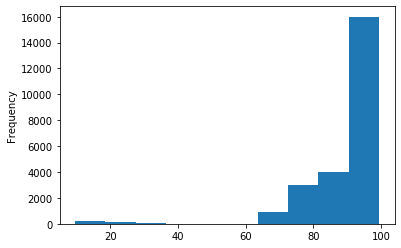

In [23]:
# plot histogram of Attendance for schools
df_attendance[df_attendance['OrganizationLevel']=='School']['Attendance'].plot(kind = 'hist')

In [24]:
# read in teacher qualification data from file

df_teacherqual = pd.read_csv('data/seattle_teacherqual.csv')

df_teacherqual.columns

Index(['[SchoolYearCode]+' School Year'', 'County', 'District Code',
       'District Name', 'District Organization Id', 'ESD Name',
       'ESD Organization Id', 'Organization', 'OrganizationCode',
       'organizationid9', 'Organizationid10',
       'OrganizationLevel (PublicDirectory)', 'OrganizationName',
       'QualitificationName', 'School Code', 'School Name',
       'School Organization Id', 'SchoolYear', 'SchoolYearCode',
       'teacher/teachers', 'Teacher Count', 'Teacher Percent',
       'Teacher Total Count'],
      dtype='object')

In [25]:
#remove single entry column
df_teacherqual = df_teacherqual.drop(['County','ESD Name','ESD Organization Id','District Code','District Name','District Organization Id',\
                                     'Organization','OrganizationCode','organizationid9','Organizationid10','OrganizationName',\
                                     'SchoolYearCode','teacher/teachers','School Name','[SchoolYearCode]+\' School Year\''],axis=1)

#change selected column names to match spelling in df_assessment
df_teacherqual.columns = ['OrganizationLevel', 'QualitificationName', 'SchoolCode', 'SchoolOrganizationid',
       'SchoolYear','Teacher Count','Teacher Percent','Teacher Total Count']

In [26]:
#remove percentage sign and change data type from object to float
df_teacherqual['Teacher Percent'] = df_teacherqual['Teacher Percent'].apply(lambda x: float(x[:-1]))


In [31]:
df_teacherqual['QualitificationName'].unique()

array(['Inexperienced status', 'Limited Certificate status',
       'Out-of-Field status'], dtype=object)

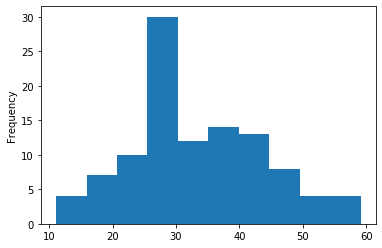

In [32]:
#plot teacher qualification data (Inexperience status)
df_teacherqual[(df_teacherqual['OrganizationLevel']=='School') & (df_teacherqual['QualitificationName']=='Inexperienced status')]\
                ['Teacher Percent'].plot(kind = 'hist')

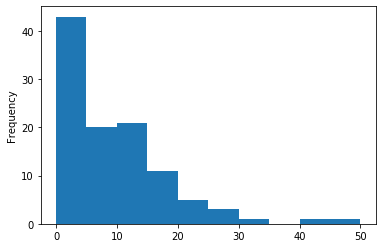

In [34]:
#plot teacher qualification data (Out-of-Field status)
df_teacherqual[(df_teacherqual['OrganizationLevel']=='School') & (df_teacherqual['QualitificationName']=='Out-of-Field status')]\
                ['Teacher Percent'].plot(kind = 'hist')

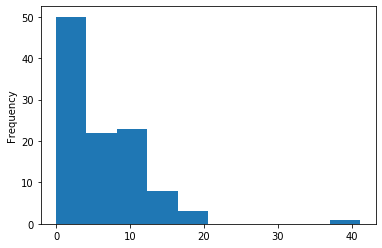

In [36]:
df_teacherqual[df_teacherqual['QualitificationName'] == 'Limited Certificate status']['Teacher Percent'].plot(kind='hist')

In [27]:
# read in teacher experience data from file
df_teacherexp = pd.read_csv('data/seattle_teacherexp.csv')

df_teacherexp.columns

Index(['County1', 'District Code', 'District Name', 'District Organization Id',
       'ESD Name', 'ESD Organization Id', 'Organization (LU Organization)',
       'OrganizationLevel (PublicDirectory)1', 's/d/st', 'School Code',
       'School Name', 'School Organization Id', 'School Year', 'N_MEAN'],
      dtype='object')

In [28]:
#remove single entry column
df_teacherexp = df_teacherexp.drop(['County1','ESD Name','ESD Organization Id','District Code','District Name','District Organization Id',\
                                     'Organization (LU Organization)','s/d/st','School Name'],axis=1)

#change selected column names to match spelling in df_assessment
df_teacherexp.columns = ['OrganizationLevel', 'SchoolCode', 'SchoolOrganizationid','SchoolYear','Teacherexp_mean']


In [29]:
# read in average class size data from file
df_classsize = pd.read_csv('data/seattle_classsize.csv')

df_classsize.columns

Index(['County', 'District Code', 'District Name', 'District Organization Id',
       'ESD Name', 'ESD Organization Id', 'Organization', 'OrganizationCode',
       'organizationid8', 'Organizationid9',
       'OrganizationLevel (PublicDirectory)', 'OrganizationName',
       'School Code', 'School Name', 'School Organization Id', 'SchoolYear',
       'Avg. Average Class Size'],
      dtype='object')

In [30]:
#remove single entry column
df_classsize = df_classsize.drop(['County','ESD Name','ESD Organization Id','District Code','District Name','District Organization Id',\
                                'Organization','OrganizationCode','organizationid8','Organizationid9','OrganizationName','School Name'],axis=1)

#change selected column names to match spelling in df_assessment
df_classsize.columns = ['OrganizationLevel', 'SchoolCode', 'SchoolOrganizationid','SchoolYear','Avg. Average Class Size']

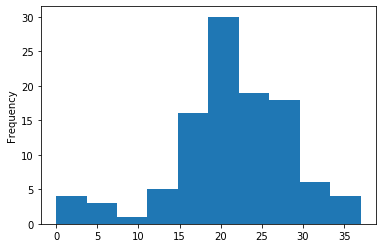

In [35]:
# plot histograms of average class size
df_classsize['Avg. Average Class Size'].plot(kind='hist')

In [38]:
# read in demographics of student body (enrolment file)
df_enrolment = pd.read_csv('data/seattle_enrolment.csv')

df_enrolment.columns

df_enrolment.head(5)

,SchoolYear,OrganizationLevel,County,ESDName,ESDOrganizationID,DistrictCode,DistrictName,DistrictOrganizationId,SchoolCode,SchoolName,...,Non-English Language Learners,Non-Foster Care,Non-Homeless,Non-Low Income,Non Migrant,Non Military Parent,Non Mobile,Non Section 504,Students without Disabilities,DataAsOf
0,2019-20,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,75.0,81.0,81.0,75.0,82.0,82,82.0,82.0,76.0,02/11/2020 12:00:00 AM
1,2018-19,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,71.0,78.0,77.0,75.0,78.0,78,75.0,77.0,73.0,02/11/2020 12:00:00 AM
2,2017-18,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,95.0,97.0,96.0,87.0,97.0,96,95.0,97.0,89.0,02/11/2020 12:00:00 AM
3,2016-17,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,103.0,107.0,104.0,88.0,107.0,108,107.0,105.0,94.0,02/11/2020 12:00:00 AM
4,2015-16,School,King,Puget Sound Educational Service District 121,100006,17001,Seattle School District #1,100229,2138.0,Adams Elementary School,...,91.0,96.0,95.0,81.0,96.0,96,94.0,96.0,90.0,02/11/2020 12:00:00 AM


In [39]:
#remove single entry column
df_enrolment = df_enrolment.drop(['County','ESDName','ESDOrganizationID','DistrictCode','DistrictName',\
                                  'DistrictOrganizationId','SchoolName','DataAsOf'],axis=1)

#change column names to match other data frames
df_enrolment.columns = ['SchoolYear','OrganizationLevel', 'SchoolCode', 'SchoolOrganizationid',
                       'CurrentSchoolType', 'GradeLevel','All Students', 'Female', 'Male', 'Gender X',
                        'American Indian/ Alaskan Native', 'Asian', 'Black/ African American',
                        'Hispanic/ Latino of any race(s)','Native Hawaiian/ Other Pacific Islander', 
                        'Two or More Races', 'White','English Language Learners', 'Foster Care', 'Homeless', 
                        'Low-Income','Migrant', 'Military Parent', 'Mobile', 'Section 504',
                        'Students with Disabilities', 'Non-English Language Learners','Non-Foster Care', 
                        'Non-Homeless', 'Non-Low Income', 'Non Migrant','Non Military Parent', 'Non Mobile', 
                        'Non Section 504','Students without Disabilities']

In [40]:
# convert enrolment number into percentage, and fill nan with 0
demographicList = ['Female', 'Male', 'Gender X',
    'American Indian/ Alaskan Native', 'Asian', 'Black/ African American',
    'Hispanic/ Latino of any race(s)','Native Hawaiian/ Other Pacific Islander', 
    'Two or More Races', 'White','English Language Learners', 'Foster Care', 'Homeless', 
    'Low-Income', 'Migrant', 'Military Parent','Mobile','Section 504','Students with Disabilities', 
    'Non-English Language Learners','Non-Foster Care','Non-Homeless','Non-Low Income', 
    'Non Migrant','Non Military Parent','Non Mobile','Non Section 504','Students without Disabilities']

for demo in demographicList:
    df_enrolment[demo] = df_enrolment[demo].fillna(0)
    df_enrolment[demo] = 100*df_enrolment[demo]/df_enrolment['All Students']

In [43]:
################### analysis set 1 : WCAS Science 5th grade performance
# S1:: [WCAS 5th Science (2018-9)] ~ [Attendance 5th 2018-9] + [Discipline 5th 2018-9] + [Budget?] + [Class size] + [Teacher exp]

# get data ready
df_m1_WCASSci_2018_5th = df_assessment[(df_assessment['GradeLevel'] == '5th Grade') & (df_assessment['SchoolYear'] == '2018-19') & \
              (df_assessment['TestAdministration'] == 'WCAS') & (df_assessment['TestSubject'] == 'Science')]

df_m1_WCASSci_2018_5th = df_m1_WCASSci_2018_5th[['OrganizationLevel', 'SchoolCode', 'SchoolOrganizationid', 'CurrentSchoolType', \
    'SchoolYear', 'StudentGroupType', 'StudentGroup', 'GradeLevel','Suppression', \
    'PercentMetStandard', 'PercentLevel1', 'PercentLevel2', 'PercentLevel3','PercentLevel4']]

print(df_m1_WCASSci_2018_5th.shape)

(1598, 14)


In [44]:
#merge Science performance data with others (attendance, discipline, avg. class size, teacher experience and demographics)
df_m1_WCASSci_2018_5th = pd.merge(df_m1_WCASSci_2018_5th, \
                                 df_attendance[['SchoolOrganizationid','SchoolYear','StudentGroup','GradeLevel','Attendance']],\
                                 how='left', on=['SchoolOrganizationid','SchoolYear','StudentGroup','GradeLevel'])

df_m1_WCASSci_2018_5th = pd.merge(df_m1_WCASSci_2018_5th, \
                        df_discipline[['SchoolOrganizationid','SchoolYear','StudentGroup','GradeLevel','DisciplineRate']],\
                        how='left', on=['SchoolOrganizationid','SchoolYear','StudentGroup','GradeLevel'])

df_m1_WCASSci_2018_5th = pd.merge(df_m1_WCASSci_2018_5th,\
                                  df_classsize[['SchoolOrganizationid','SchoolYear','Avg. Average Class Size']],\
                                  how='left', on=['SchoolOrganizationid','SchoolYear'])

df_m1_WCASSci_2018_5th = pd.merge(df_m1_WCASSci_2018_5th,\
                                  df_teacherexp[['SchoolOrganizationid','SchoolYear','Teacherexp_mean']],\
                                  how='left', on=['SchoolOrganizationid','SchoolYear'])

df_m1_WCASSci_2018_5th = pd.merge(df_m1_WCASSci_2018_5th,\
                        df_enrolment[['SchoolYear','SchoolOrganizationid','GradeLevel','Female','Asian',
                                      'Black/ African American','Hispanic/ Latino of any race(s)','White',
                                      'English Language Learners','Foster Care','Homeless','Low-Income',
                                      'Students with Disabilities',]], how='left', 
                                      on=['SchoolOrganizationid','SchoolYear','GradeLevel'])

In [45]:
# check for null values
df_m1_WCASSci_2018_5th.isnull().sum().sort_values(ascending=False)

Attendance                         965
PercentLevel4                      640
PercentLevel1                      640
PercentLevel3                      640
PercentLevel2                      640
PercentMetStandard                 558
DisciplineRate                     535
CurrentSchoolType                   26
SchoolOrganizationid                26
SchoolCode                          26
Teacherexp_mean                     12
Avg. Average Class Size             12
SchoolYear                           0
StudentGroupType                     0
StudentGroup                         0
Suppression                          0
GradeLevel                           0
Students with Disabilities           0
Low-Income                           0
Female                               0
Asian                                0
Black/ African American              0
Hispanic/ Latino of any race(s)      0
White                                0
English Language Learners            0
Foster Care              

In [46]:
############# imputation ############

imputer = KNNImputer(n_neighbors=2, weights="uniform")

In [47]:
# impute for subset of data that will be used to build model, which is StudentGroup == 'All students' and GradeLevel == 5th 
df_im_m1 = df_m1_WCASSci_2018_5th[(df_m1_WCASSci_2018_5th['StudentGroup']=='All Students') & \
                                  (df_m1_WCASSci_2018_5th['OrganizationLevel']=='School')].copy()

df_im_m1.reset_index(inplace=True)


In [49]:
# run imputation
df_im_m1[['Attendance','DisciplineRate','Avg. Average Class Size','Teacherexp_mean',\
            'Female','Asian','Black/ African American','Hispanic/ Latino of any race(s)',\
            'White','English Language Learners','Foster Care','Homeless','Low-Income',\
            'Students with Disabilities']] \
            = imputer.fit_transform(df_im_m1[['Attendance','DisciplineRate','Avg. Average Class Size','Teacherexp_mean',\
                               'Female','Asian','Black/ African American','Hispanic/ Latino of any race(s)',\
                                'White','English Language Learners','Foster Care','Homeless','Low-Income',\
                                'Students with Disabilities']])


In [50]:
# write imputed data frame to csv file for beta regression modeling in Rstudio
df_im_m1.to_csv("data/m1_WCASSci_2018_5th_Allstudents.csv",index=False)